In [17]:
import weightwatcher as ww
import matplotlib.pyplot as plt
import numpy as np
import powerlaw

### This experiment is inspired by https://calculatedcontent.com/2018/09/14/power-laws-in-deep-learning-2-universality/

In [2]:
ww.__file__

'/home/ubuntu/test_ww/WeightWatcher2/WeightWatcher/weightwatcher/__init__.py'

In [3]:
def generate_pdfs(mu = 1):
    N, M = 1000, 500
    Q = N / M
    #W = np.random.normal(0,1,size=(M,N))
    W=np.random.pareto(mu,size=(N,M))
    # X shape is M x M
    X = (1/N)*np.dot(W.T,W)
    evals = np.linalg.eigvals(X)

    # This mimics the usual behavior of NNs, which do not have extremely large evals
    # One can change the constant here to see how the exponential truncation changes with the scale
    evals = evals/10000
    evals = evals[5:]
    
    return evals

In [ ]:
num_exps = 20
alphas_final = []
lambdas_final = []
mu_list = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

for mu in mu_list:
    alphas = []
    lambdas = []
    for exp in range(num_exps):
        evals = generate_pdfs(mu = mu)
        watcher = ww.WeightWatcher(model=None)
        new_fit = watcher.fit_powerlaw(evals, xmax = np.max(evals), plot=False, distribution='truncated_power_law')
        alphas.append(new_fit[0])
        lambdas.append(new_fit[-2])
    alphas_final.append(np.mean(alphas))
    lambdas_final.append(np.mean(lambdas))

Text(0, 0.5, 'lambda: exponential truncation coefficient')

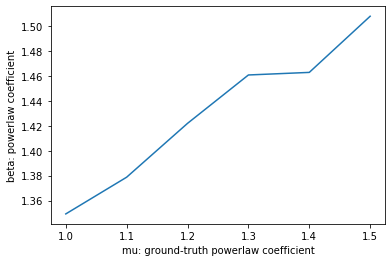

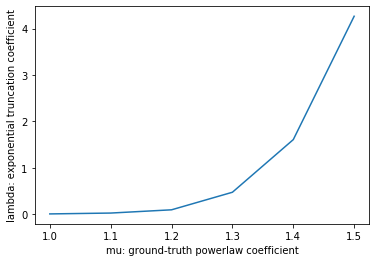

In [16]:
mu_list = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
fig, ax = plt.subplots()
ax.plot(mu_list, alphas_final)
ax.set_xlabel("mu: ground-truth powerlaw coefficient")
ax.set_ylabel("beta: powerlaw coefficient")

fig, ax = plt.subplots()
ax.plot(mu_list, lambdas_final)
ax.set_xlabel("mu: ground-truth powerlaw coefficient")
ax.set_ylabel("lambda: exponential truncation coefficient")

# Some conclusions here.

### 1. When the powerlaw distribution becomes less heavy-tail, both beta and lambda can determine that
### 2. The beta is something that does not change with scale. However, lambda changes significantly with scale